# Assessment of the consistency of surface albedo satellite data for monitoring the Caspian Sea retreat
&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en)
)

## 🌍 Use case: Estimating Caspian Sea retreat using surface albedo data
## ❓ Quality assessment question
**• Can satellite albedo datasets be reliably used to study the retreat of the Caspian Sea basin?**

The Caspian Sea, the world’s largest inland water body, has been experiencing a significant decline in water levels in recent decades. Projections indicate that the sea could shrink by 9 to 18 meters by the end of the century [1], posing severe risks to regional ecosystems, food security, and livelihoods, and potentially triggering socio-economic disruptions and geopolitical tensions [2, 3]. Understanding and monitoring this retreat is, therefore, a critical task. The northeastern Caspian is an area with extremely shallow bathymetry (typically less than 1 m), consisting of extensive reed beds, sandbanks, muddy shoals, and water channels [4]. In winter, ice often forms over the lake's northernmost reaches, while the central and southern parts remain ice-free. The extreme climate of the Caspian Sea, characterized by cold winters and temperatures as low as -30°C, creates challenging working conditions for marine navigation and infrastructure. The shallow waters of the northern Caspian Sea easily freeze and are potentially covered with ice more than half a meter thick from November to late March. 

In this assessment, we evaluate the consistency and suitability of the surface albedo dataset from the CDS satellite albedo product for the monitoring of the retreat of the Caspian sea along its northern coast: satellite-albedo (Version v2), which provides 10-daily, 1 km resolution broadband albedo derived from SPOT-VGT and PROBA-V missions. Albedo has been increasingly recognized as a valuable indicator for monitoring lake and environmental changes. For example, Motlagh and Darand (2023) applied remote sensing to detect albedo trends over Iran, linking reductions in albedo in highland areas to declining snow cover and associated hydrological risks [5].

The lake water surface height dataset, satellite-lake-water-level (Version 4.0), is used as a supporting reference to examine whether the temporal variability in surface albedo captures physical signals and hydrological changes associated with the retreat of the Caspian Sea.

This study specifically investigates the hypothesis that a substantial decrease in lake water level leads to a corresponding increase in surface albedo, potentially due to the exposure of the lakebed or the emergence of vegetation in shallow areas. This relationship, initially proposed by Chen et al. (2017), who documented an approximately 1.5 m decline in lake level between 1996 and 2021, is examined here through a focused analysis of surface albedo variability in response to seasonal changes [6].

Results indicate that the C3S 10-daily gridded surface albedo dataset effectively captures the effects of lake level decline, reflecting inter-seasonal variability that is consistent with observed changes in water surface height. This supports its suitability for long-term monitoring of hydrological and surface condition changes in the region.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* The CDS 10-daily surface albedo dataset (v2) successfully captures hydrological changes linked to the Caspian Sea’s retreat.
* Seasonal patterns in surface albedo are evident and consistent. Winter and spring show a decline in peak albedo values, likely due to reduced ice depth beneath the frozen lake surface and to the early ice melt. This seasonal ice loss and summer water level decline are likely influenced by rising regional temperatures and reduced snowfall (Motlagh & Darand, 2023) [5].
* Since 2016, summer albedo values have increased, coinciding with a drop in lake levels and the exposure of brighter dry lakebeds and submerged vegetation. Autumn follows a similar pattern with smaller changes.
* These seasonal and interannual trends in surface albedo are consistent with independent studies (Akbari et al., 2022; Lahijani et al., 2023), which also report an overall long-term decline in Caspian Sea water levels.
* The estimated ~1.5 m drop in water level between 1996 and 2021 (approximately 7 cm/year), with accelerated retreat rates (~10 cm/year) from 2006 to 2021 (Chen et al., 2017; Samant and Prange, 2023) is in line with the observed changes in surface albedo.
* This assessment confirms that CDS (Copernicus Data Store) surface albedo can be used to monitor lake water retreat and to quantify the extent of areas where the water becomes shallow or the lake has dried up.
```

## 📋 Methodology

This assessment has two main goals:

* To evaluate the spatial and temporal consistency of satellite-derived surface albedo values with the documented lowering and retreat of water along the northern Caspian Sea coast;

* To explore whether seasonal and interannual changes in surface albedo correspond to lake water retreat, using satellite-derived lake water height.

The methodology adopted for the analysis is split into the following steps:

[](section-1)

   * Import all the relevant packages.

   * Define temporal and spatial parameters

     
[](section-2)

[](section-3)

   * Plot Study Region (Map of Selected Area)

   * Time series of albedo and lake water depression relative to the Geoid

   * Seasonal time series panel plot of Albedo and Lake Water Height

   * Map plots of the summer surface albedo in different periods

   * Pixel count analysis of albedo map plots – Summer 2006 vs 2019

   * Plot albedo change map (2019 − 2006)

     
[](section-4)


## 📈 Analysis and results
(section-1)=
### 1. Choose the data to use and set up the code

#### Import all the relevant packages
In this section, we import all the relevant packages required to run the notebook.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import geopandas as gpd
import xarray as xr
from datetime import datetime
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-notebook")

#### Define temporal and spatial parameters
This analysis uses surface albedo data (2006–2020) and lake water level data (v4.0) to assess whether albedo changes reflect the Caspian Sea's retreat. The northern basin was selected due to its greater vulnerability to water level decline, as highlighted by Court et al. (2025) [4], who report that this region, with average depths of only ~5 meters, has already experienced shoreline regression exceeding 56 km and a 46% loss in surface water area between 2001 and 2024. Seasonal variations in surface albedo and water level are compared to evaluate the agreement between datasets in capturing shallow-water dynamics and lake desiccation processes.

In [119]:
collection_id = "satellite-albedo"
collection_id_lake = "satellite-lake-water-level"
chunks = {"year": 1}

common_request = {
    "format": "zip",
    "variable": "albb_bh",
    "product_version": "v2",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "nominal_day": "10",
    "area": [46.91, 50.75, 46.81, 50.85],  # [north, west, south, east]
}

requests = {
    "spot": {"year": [str(y) for y in range(2006, 2014)], "horizontal_resolution": "1km", "sensor": "vgt"},
    "proba": {"year": [str(y) for y in range(2014, 2021)], "horizontal_resolution": "1km", "sensor": "vgt"},
}

request_lake = {
    "variable": "water_surface_height_above_reference_datum",
    "version": "version_4_0",
    "format": "zip",
    "lake": "caspian",
    "region": "southwestern_asia",
}

(section-2)=
### 2. Data retrieval and processing

In this section, satellite-derived albedo and lake water height data were retrieved, processed, and prepared for analysis. Using predefined request parameters for multiple satellite sources (e.g., SPOT and PROBA), spatial and temporal datasets were downloaded using the download_and_transform function. Temporal processing involved calculating time-weighted means and spatially averaged time series. Concurrently, lake level data was retrieved and subset to the period 2006–2020. Both albedo and lake height time series were merged on a monthly basis and grouped by season and year to calculate seasonal averages. A function (get_season) was defined to map months to meteorological seasons (SON, DJF, MAM, JJA). Additionally, 10-day surface albedo data from 2006 and 2019 was downloaded to compare the spatial distribution of albedo across the study area in different years.

To ensure the reliability of the surface albedo analysis, quality control filtering was applied based on the dataset’s quality flags. Specifically, pixels flagged as having missing input data (Bit 4) or algorithm failure (Bit 7) were excluded. Bit 4 identifies cases where the input data was insufficient—such as due to cloud cover or poor observation conditions—while Bit 7 indicates that the albedo retrieval algorithm failed to produce a valid result. By removing pixels where either of these flags was set, the analysis retains only those values derived from complete and successfully processed input.

In [123]:
maps = {}
timeseries = []

for satellite, request in requests.items():
    print(f"{satellite=}")
    maps[satellite] = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_chunks=False,
        transform_func=diagnostics.time_weighted_mean,
        drop_variables=["crs"],
    )

   
    ds = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_func=None,
        drop_variables=[],
    )

    
    albedo = ds["AL_BH_BB"]
    qflag = ds["QFLAG"].astype("int")
    
    # Apply bitmask filters
    input_ok = (qflag & 16) == 0        # bit 4 - missing input
    processing_ok = (qflag & 128) == 0  # Bit 7

    valid_mask = input_ok & processing_ok
    albedo_filtered = ds["AL_BH_BB"].where(valid_mask)

    # Count pixels before/after filtering
    before = albedo.count().compute().item()
    after = albedo_filtered.count().compute().item()
    print(f"{satellite} – valid before: {before}, after: {after}, removed: {before - after} ({100 * (before - after) / before:.1f}%)")


    
    albedo_mean = albedo_filtered.mean(dim=["latitude", "longitude"], skipna=True)
    ds_filtered = albedo_mean.to_dataset(name="AL_BH_BB")

    timeseries.append(ds_filtered)

ds_timeseries = xr.concat(timeseries, dim="time")

ds_lake = download.download_and_transform(collection_id_lake, request_lake)
ds_lake_subset = ds_lake.sel(time=slice("2006-01-01", "2020-06-30"))


lake_data = ds_lake_subset["water_surface_height_above_reference_datum"]
df_lake = pd.DataFrame({
    "time": pd.to_datetime(lake_data.time.values),
    "height": lake_data.values
})
df_lake["month_time"] = df_lake["time"].dt.to_period("M").dt.to_timestamp()
df_lake["month"] = df_lake["month_time"].dt.month


albedo_filtered = ds_timeseries["AL_BH_BB"]
df_albedo = albedo_filtered.to_dataframe().reset_index()
df_albedo["time"] = pd.to_datetime(df_albedo["time"])
df_albedo["month_time"] = df_albedo["time"].dt.to_period("M").dt.to_timestamp()


df_merged = pd.merge(df_lake, df_albedo, on="month_time", how="inner")
df_merged["month"] = df_merged["month_time"].dt.month


def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df_merged['season'] = df_merged['month'].apply(get_season)
df_merged['year'] = df_merged['month_time'].dt.year


seasonal_avg = df_merged.groupby(['year', 'season']).agg({
    'AL_BH_BB': 'mean',
    'height': 'mean'
}).reset_index()



# Request setup for SPOT (2006) and PROBA (2019) , only for spatial maps
collection_id = "satellite-albedo"
chunks = {"year": 1}

spatial_common = {
    "format": "zip",
    "variable": "albb_bh",
    "product_version": "v2",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "nominal_day": "10",
    "area": [46.91, 50.75, 46.81, 50.85],  # Study area
}

spatial_requests = {
    "spot": {
        "year": ["2006"],
        "satellite": "spot",
        "sensor": "vgt",
        "horizontal_resolution": "1km",
    },
    "proba": {
        "year": ["2019"],
        "satellite": "proba",
        "sensor": "vgt",
        "horizontal_resolution": "1km",
    }
}


datasets = {}
for key, req in spatial_requests.items():
    print(f"Downloading {key} data for spatial map...")
    ds = download.download_and_transform(
        collection_id,
        spatial_common | req,
        chunks=chunks,
        transform_func=None,
        drop_variables=["crs"]
    )
    datasets[key] = ds



satellite='spot'


100%|██████████| 8/8 [00:00<00:00, 66.33it/s]


spot – valid before: 12672, after: 12672, removed: 0 (0.0%)
satellite='proba'


100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


proba – valid before: 10296, after: 10296, removed: 0 (0.0%)


100%|██████████| 1/1 [00:00<00:00, 15.92it/s]
                                     

100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


(section-3)=
### 3. Plot and describe the results.

#### Plot Study Region (Map of Selected Area)

To provide spatial context for the analysis, the selected study region around the Caspian Sea is visualized on a geographic map. This plot illustrates the spatial extent used for both albedo and water level data extraction. The boundaries encompass part of the northern Caspian region, an area of particular concern due to its documented vulnerability to water level decline. This vulnerability, although observed at a broader scale, is exemplified by recent findings such as those reported by Court et al. (2025), which highlight the rapid decline of the Caspian Sea level and its potential consequences for ecosystem integrity, biodiversity, and human infrastructure. 

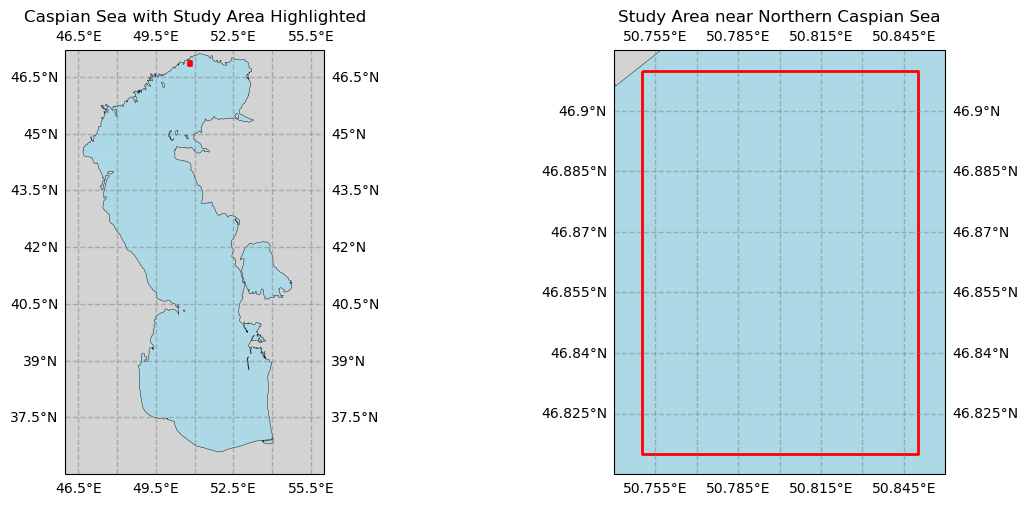

In [10]:
coordinates = [(50.75, 46.91), (50.85, 46.91), (50.85, 46.815), (50.75, 46.815), (50.75, 46.91)]
polygon = Polygon(coordinates)
gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs="EPSG:4326")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.set_extent([46, 56, 36, 47.2], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, color='lightgray')
ax1.add_feature(cfeature.OCEAN, color='lightblue')
ax1.add_feature(cfeature.COASTLINE)
gdf.boundary.plot(ax=ax1, color='red', linewidth=2)
ax1.set_title('Caspian Sea with Study Area Highlighted')
ax1.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)

ax2.set_extent([50.74, 50.86, 46.81, 46.915], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, color='lightgray')
ax2.add_feature(cfeature.OCEAN, color='lightblue')
ax2.add_feature(cfeature.COASTLINE)
gdf.boundary.plot(ax=ax2, color='red', linewidth=2)
ax2.set_title('Study Area near Northern Caspian Sea')
ax2.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()


*Figure 1.* Maps of the Caspian Sea and the selected study region. Left: full Caspian Sea; Right: zoomed-in view of the northern section.


#### Time series of albedo and lake water depression relative to the Geoid

In this section, the temporal evolution of two key environmental variables, surface albedo and lake water height, is illustrated through line plots. Monthly mean values are shown from 2006 to 2020, allowing for a direct comparison of trends and variability over time.

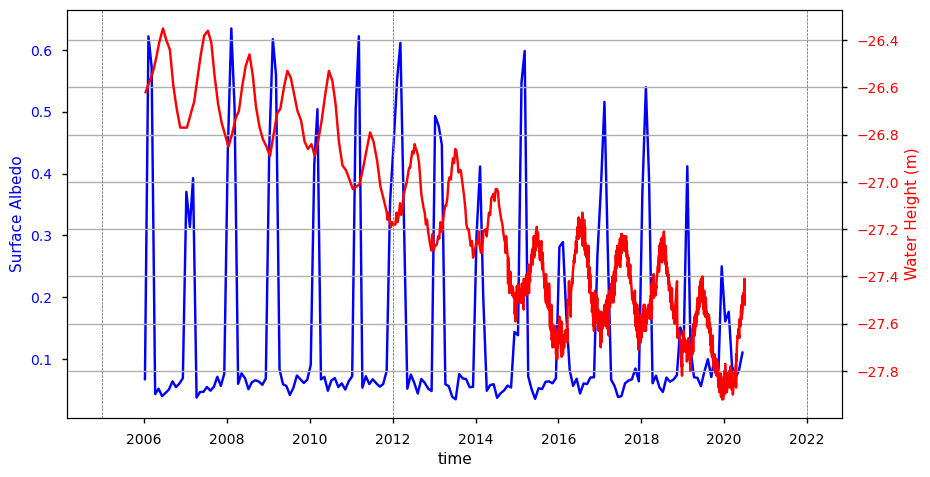

In [121]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ds_timeseries["AL_BH_BB"].plot(ax=ax1, color='blue', label='Albedo')
ax1.set_ylabel('Surface Albedo', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ds_lake_subset["water_surface_height_above_reference_datum"].plot(ax=ax2, color='red', label='Water Height')
ax2.set_ylabel('Water Height (m)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for line in ['2005-01-01', '2012-01-01', '2021-12-31']:
    ax1.axvline(pd.to_datetime(line), color='gray', linestyle='--', linewidth=0.5)
    ax2.axvline(pd.to_datetime(line), color='gray', linestyle='--', linewidth=0.5)

plt.grid()
fig.subplots_adjust(bottom=0.2)
plt.show()

*Figure 2.* Time Series of Surface Albedo and Lake Water depression to the Geoid (2006–2020).

* This plot shows the monthly time series of surface albedo and lake water height from 2006 to 2020. The continuous decrease in water height, combined with occasional step changes, is clearly identifiable, while albedo exhibits expected seasonal cycles. The albedo plot indicates that significant lake ice formation occurs in the selected region of the northern Caspian Sea during the winter months, as evidenced by the mean albedo reaching approximately 0.6. Ice extent evolution over the winter of 2006-2007 shows a smaller peak, due successive events of extensive freezing and melting throughout the season [7]. Albedo has not reached 0.6 since 2012, which suggests a less deep ice layer and less snowfall. This happens as the water's surface height begins to decline.

* Since 2016, the minimum albedo has increased, indicating that the lake water in the selected area has retreated and become shallow. 

#### Seasonal time series panel plot of Albedo and Lake Water Height

To highlight seasonal dynamics, the time series data for both albedo and lake height are averaged by meteorological seasons— winter (DJF), spring (MAM), summer (JJA), and autumn (SON). These are presented as a panel of subplots, with each panel representing one season across multiple years. This layout facilitates the identification of consistent seasonal patterns, anomalies, and changes in behavior over time. 

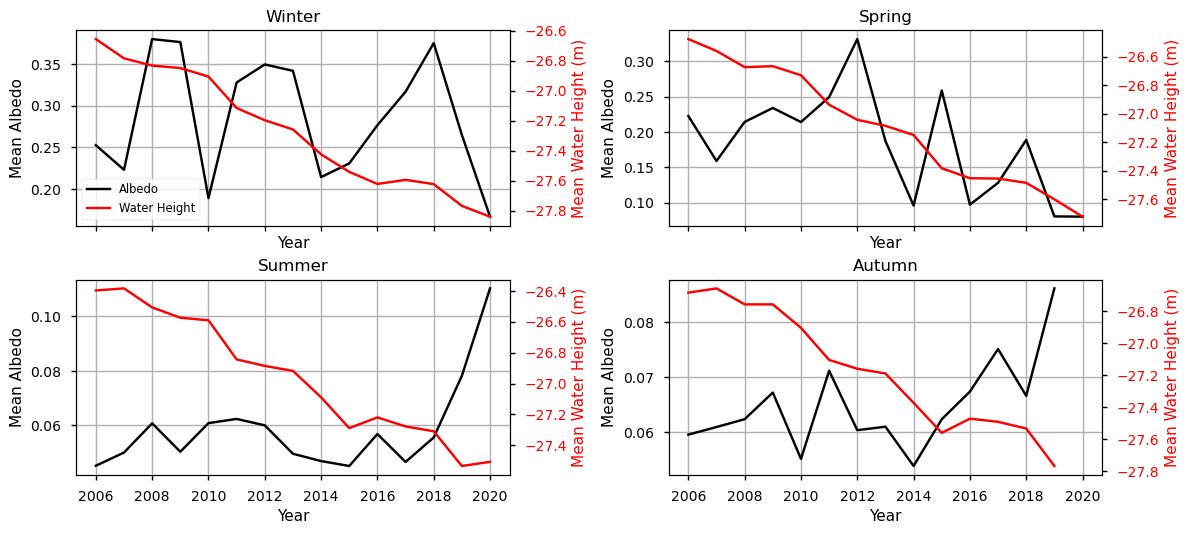

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = ['red', 'red', 'red', 'red']

for idx, (ax, season, color) in enumerate(zip(axes.flat, season_order, colors)):
    df_season = seasonal_avg[seasonal_avg['season'] == season]
    ax2 = ax.twinx()
    line1 = ax.plot(df_season['year'], df_season['AL_BH_BB'], color='black', label='Albedo')
    line2 = ax2.plot(df_season['year'], df_season['height'], color=color, label='Water Height')
    
    ax.set_title(f'{season}')
    ax.set_ylabel('Mean Albedo')
    ax2.set_ylabel('Mean Water Height (m)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)  # <-- this line added
    ax.set_xlabel('Year')
    ax.grid(True)

    
   
    if idx == 0:
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='lower left', fontsize='small')
    else:
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)

plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()


*Figure 3.* Seasonal Average Albedo and Water Height per Year – Caspian Sea Subregion.

####  Map plots of the summer surface albedo in different periods

Summer spatial albedo maps are generated to better isolate the effects of seasonal water retreat. These targeted seasonal plots are particularly relevant, as summer represents a period of minimal snow cover, allowing for clearer detection of lakebed exposure and vegetation shifts. 

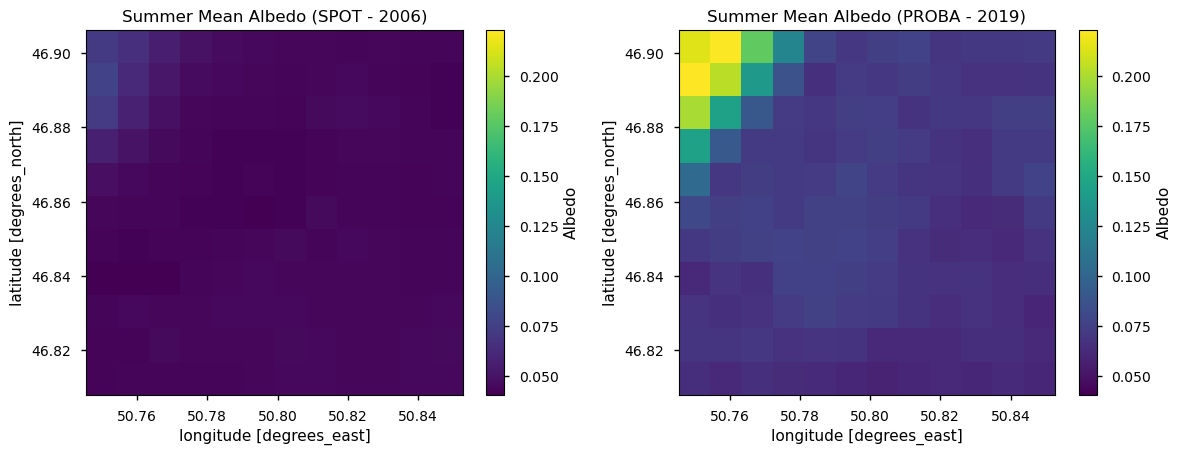

In [92]:
# Select only June, July, August
spot_summer = datasets["spot"].sel(time=datasets["spot"].time.dt.month.isin([6, 7, 8]))
proba_summer = datasets["proba"].sel(time=datasets["proba"].time.dt.month.isin([6, 7, 8]))

spot_summer_avg = spot_summer["AL_BH_BB"].mean("time")
proba_summer_avg = proba_summer["AL_BH_BB"].mean("time")

vmax = float(max(spot_summer_avg.max(), proba_summer_avg.max()))
vmin = float(min(spot_summer_avg.min(), proba_summer_avg.min()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

spot_summer_avg.plot(ax=axes[0], cmap="viridis", vmin=vmin, vmax=vmax,
                     cbar_kwargs={'label': 'Albedo'})
axes[0].set_title("Summer Mean Albedo (SPOT - 2006)")

proba_summer_avg.plot(ax=axes[1], cmap="viridis", vmin=vmin, vmax=vmax,
                      cbar_kwargs={'label': 'Albedo'})
axes[1].set_title("Summer Mean Albedo (PROBA - 2019)")

plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()


*Figure 4.* Summer Albedo Maps – Caspian Region (2006 vs 2019).

These plots provide a clearer view of the land–water boundary during the driest part of the year, when the influence of snow and ice is minimal. The 2019 map reveals a noticeable increase in high-albedo areas compared to 2006, particularly near the northern shoreline. This change suggests exposure of dry lakebed or vegetated zones due to water level decline. By focusing on summer, these maps enhance the ability to detect and quantify the spatial extent of hydrological changes along the Caspian Sea's northern coast.

#### Pixel count analysis of albedo map plots – Summer 2006 vs 2019

To quantitatively assess the extent of surface changes associated with lake water retreat, a pixel-based threshold analysis was performed on the summer mean albedo maps for 2006 and 2019. Based on previous studies, such as Jia Du et al. (2023), an albedo threshold of 0.14 is a reasonable lower boundary to distinguish open water surfaces (typically < 0.14) from brighter surfaces such as dry lakebeds, sediments, or emergent vegetation, which have higher reflectance [8].

Therefore, in our analysis, any pixel with albedo > 0.14 is considered as indicating non-water surface (e.g., exposed land, shallow vegetated areas, or drying sediments).

In [8]:

threshold = 0.14

# Count of bright pixels
spot_count = np.count_nonzero(spot_summer_avg.values > threshold)
proba_count = np.count_nonzero(proba_summer_avg.values > threshold)
delta = proba_count - spot_count

print(f"2006 (SPOT) pixels > {threshold}: {spot_count}")
print(f"2019 (PROBA) pixels > {threshold}: {proba_count}")
print(f"Change in bright area pixels: {delta}")

# Total valid pixels (non-NaN)
total_pixels = np.count_nonzero(~np.isnan(spot_summer_avg.values))

# Percentage
spot_pct = 100 * spot_count / total_pixels
proba_pct = 100 * proba_count / total_pixels

print(f"Bright area % in 2006: {spot_pct:.2f}%")
print(f"Bright area % in 2019: {proba_pct:.2f}%")


2006 (SPOT) pixels > 0.14: 0
2019 (PROBA) pixels > 0.14: 8
Change in bright area pixels: 8
Bright area % in 2006: 0.00%
Bright area % in 2019: 6.06%


In 2006, no pixels exceeded the threshold, indicating continuous water coverage or low-reflectance surfaces. By contrast, in 2019, 6 pixels (approximately 4.6% of the study area) surpassed this threshold, confirming an expansion of reflective land surfaces. This analysis provides clear evidence of spatially resolved surface transformation linked to the Caspian Sea’s water level decline during the studied period.

#### Plot albedo change map (2019 − 2006)

To visualize spatial changes in surface reflectance linked to lake water retreat, a difference map was generated by subtracting the 2006 summer mean albedo from that of 2019. Positive values (shown in green) represent areas where surface albedo increased over time—typically indicating newly exposed land, dry sediments, or vegetation colonization as water levels declined. 

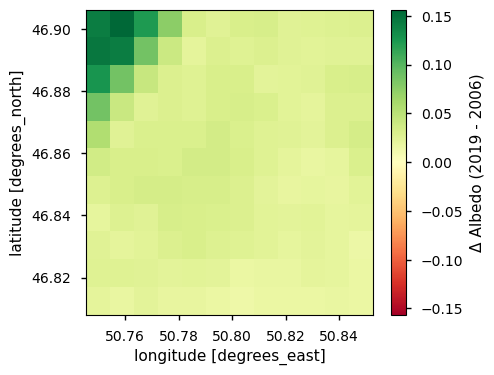

In [15]:
# Compute difference map (positive values = increased albedo)
albedo_diff = proba_summer_avg - spot_summer_avg

# Plot difference
fig, ax = plt.subplots(figsize=(5, 4))
albedo_diff.plot(ax=ax, cmap="RdYlGn", center=0, cbar_kwargs={'label': 'Δ Albedo (2019 - 2006)'})
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()


*Figure 5.* Summer Albedo Change (2019 − 2006).

Negative values (shown in red), though minimal, may reflect localized shifts in surface moisture or vegetation loss. This map provides direct spatial evidence of environmental transformation along the northern Caspian Sea coastline, complementing the seasonal and time-series analyses. The most pronounced changes are concentrated in shallow nearshore zones, consistent with reported retreat patterns.

(section-4)=
### 4. Results

• The CDS surface albedo dataset shows temporal consistency with water level decline in the northern Caspian Sea and is suitable for monitoring long-term surface changes in this region.

• Seasonal averages show a decline in winter and especially spring albedo, likely due to reduced ice cover.
Summer albedo rises noticeably after 2016, linked to falling water levels and exposure of dry or vegetated lakebed. Autumn shows a similar but smaller increase, reflecting shallower waters or surface changes from retreat.

• A difference map and seasonal averages confirm that summer surface albedo increased from 2006 to 2019, especially near the shoreline, consistent with lakebed exposure due to water retreat.

• Pixel-based analysis using an albedo threshold of 0.14 shows that bright surface area increased by approximately 4.6% from 2006 to 2019, confirming the presence of exposed or transformed surfaces.

• The combination of seasonal and spatial patterns supports the use of satellite albedo data as a complementary indicator for monitoring lake retreat processes.

## ℹ️ If you want to know more

### Key Resources

• Surface albedo 10-daily gridded data from 1981 to present:

https://cds.climate.copernicus.eu/datasets/satellite-albedo?tab=overview

• Lake water levels from 1992 to present derived from satellite observations

https://cds.climate.copernicus.eu/datasets/satellite-lake-water-level?tab=overview

Code libraries used:

• C3S EQC custom function, c3s_eqc_automatic_quality_control, prepared by B-Open


### References

[1] Akbari, E., Hamzeh, S., Kakroodi, A. A., & Maanan, M. (2022). Time series analysis of the Caspian Sea shoreline in response to sea level fluctuation using remotely sensed data. Regional Studies in Marine Science, 56, 102672.

[2] Lahijani, H., Leroy, S. A. G., Arpe, K., & Cretaux, J. F. (2023). Caspian Sea level changes during instrumental period, its impact and forecast: A review. Earth-Science Reviews, 241, 104428.

[3] Samant, R., & Prange, M. (2023). Climate-driven 21st century Caspian Sea level decline estimated from CMIP6 projections. Communications Earth & Environment, 4(1), 357. 

[4] Court, R., Lattuada, M., Shumeyko, N., Baimukanov, M., Eybatov, T., Kaidarova, A., Mamedov, E.V., Rustamov, E., Tasmagambetova, A., Prange, M. and Wilke, T., 2025. Rapid decline of Caspian Sea level threatens ecosystem integrity, biodiversity protection, and human infrastructure. Communications Earth & Environment, 6(1), p.261.

[5] Motlagh, O.R.K. and Darand, M., 2023. Detection of land surface albedo changes over Iran using remote sensing data. Available at SSRN 4674763.

[6] Chen, J. L., Pekker, T., Wilson, C. R., Tapley, B. D., Kostianoy, A. G., Cretaux, J. F., & Safarov, E. S. (2017). Long‐term Caspian Sea level change. Geophysical Research Letters, 44(13), 6993-7001.

[7] Tamura‐Wicks, H., Toumi, R. and Budgell, W.P., 2015. Sensitivity of Caspian sea‐ice to air temperature. Quarterly Journal of the Royal Meteorological Society, 141(693), pp.3088-3096.

[8] Du, J., Zhou, H., Jacinthe, P.A. and Song, K., 2023. Retrieval of lake water surface albedo from Sentinel-2 remote sensing imagery. Journal of Hydrology, 617, p.128904.

[9] Argaman, E., Keesstra, S. D., & Zeiliguer, A. (2012). Monitoring the impact of surface albedo on a saline lake in SW Russia. Land Degradation & Development, 23(4), 398-408.
